In [16]:
!pip -q install imbalanced-learn xgboost lightgbm catboost

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, log_loss, brier_score_loss,
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

In [18]:
import warnings; warnings.filterwarnings("ignore")
np.random.seed(42)

In [19]:
# Загрузка реального датасета (OpenML)
df = fetch_openml(name='creditcard', version=1, as_frame=True)
X = df.data
y = df.target.astype(int)

pos_rate = y.mean()
X.shape, pos_rate

((284807, 29), np.float64(0.001727485630620034))

In [20]:
data = X.copy()
data['target'] = y

negative_samples = data[data['target'] == 0].sample(n=60000, random_state=42)
positive_samples = data[data['target'] == 1]

sampled_data = pd.concat([negative_samples, positive_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Разделение обратно на X и y
X_sampled = sampled_data.drop('target', axis=1)
y_sampled = sampled_data['target']

In [21]:
pos_rate = y_sampled.mean()
X_sampled.shape, pos_rate

((60492, 29), np.float64(0.00813330688355485))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, stratify=y_sampled, random_state=42
)

In [23]:
def report_metrics(y_true, y_proba, threshold=0.5, title=""):
    y_pred = (y_proba >= threshold).astype(int)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"{title}\nROC-AUC={roc_auc:.4f}  PR-AUC={pr_auc:.4f}  Brier={brier:.4f}")
    print(f"Confusion threshold={threshold:.2f}: TP={tp} FP={fp} FN={fn} TN={tn}")

In [24]:
def plot_curves(y_true, y_proba, title=""):
    precision, recall, threshold = precision_recall_curve(y_true, y_proba)
    fpr, tpr, thr = roc_curve(y_true, y_proba)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel("Recall");
    plt.ylabel("Precision")
    plt.title("PR-curve")

    plt.subplot(1, 2, 2)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-curve")
    plt.suptitle(title)
    plt.show()

### Дисбаланс и метрики - как не промахнуться

**PR-curve** строится путём варьирования порога классификации от 0 до 1 и отображения зависимости Precision (ось Y) от Recall (ось X).

**PR-AUC** — это площадь под этой кривой, которая интерпретируется как средняя точность всех возможных уровней полноты.

**Brier Score** - для бинарной классификации метрика вычисляется как средняя квадратичная ошибка между предсказанной вероятностью и фактическим исходом

- Значение Brier Score лежит в диапазоне от 0 до 1
- Brier Score специально разработана для оценки калибровки вероятностных предсказаний. Калибровка означает, что предсказанные вероятности соответствуют реальной частоте событий. Например, если откалиброванная модель предсказывает вероятность события 70%, то это событие должно происходить примерно в 70% случаев в аналогичных ситуациях.
- В отличие от метрик классификации (точность, полнота), которые работают с жёсткими классами, Brier Score штрафует неправильную уверенность моделей:
  - если модель предсказывает вероятность 0.9, а событие не произойдёт (0), штраф будет большим: $(0.9-0)^2=0.81$
  - если модель предсказывает вероятность 0.1, и событие не произойдёт (0), штраф меньше: $(0.1-0)^2=0.01$
- нечувствительна к редким событиям - при сильном дисбалансе классов редкие события слабо влияют на общее значение метрики
- смешивает два аспекта - Brier Score объединяет оценку калибровки с дискриминационной способностью, поэтому улучшение по одному аспекту может замаскировать проблемы с другим

Dummy
ROC-AUC=0.5000  PR-AUC=0.0081  Brier=0.0080
Confusion threshold=0.50: TP=0 FP=0 FN=98 TN=12001


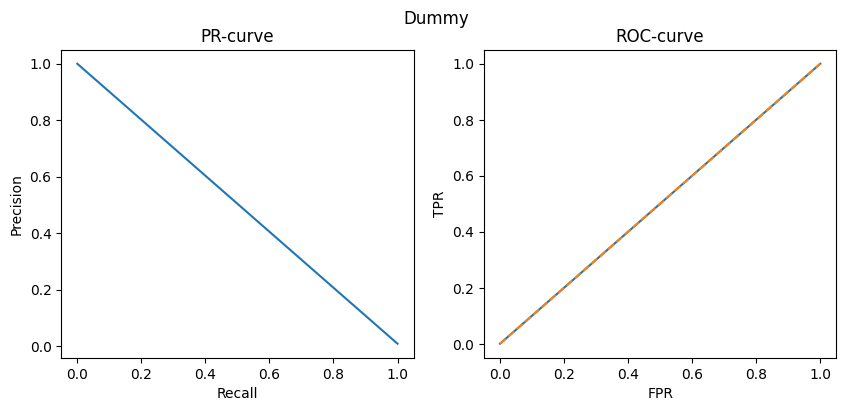

In [25]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
proba_dummy = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
report_metrics(y_test, proba_dummy, title="Dummy")
plot_curves(y_test, proba_dummy, "Dummy")

LogReg (no weights)
ROC-AUC=0.9852  PR-AUC=0.8845  Brier=0.0017
Confusion threshold=0.50: TP=81 FP=6 FN=17 TN=11995


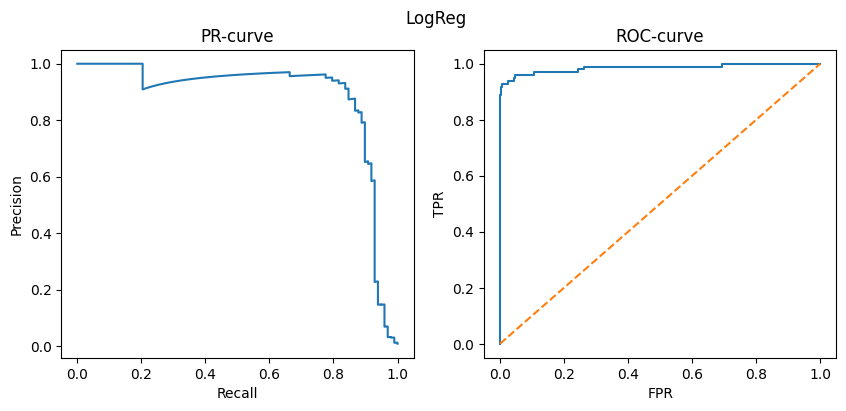

In [26]:
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
proba_lr = lr.predict_proba(X_test)[:,1]
report_metrics(y_test, proba_lr, title="LogReg (no weights)")
plot_curves(y_test, proba_lr, "LogReg")

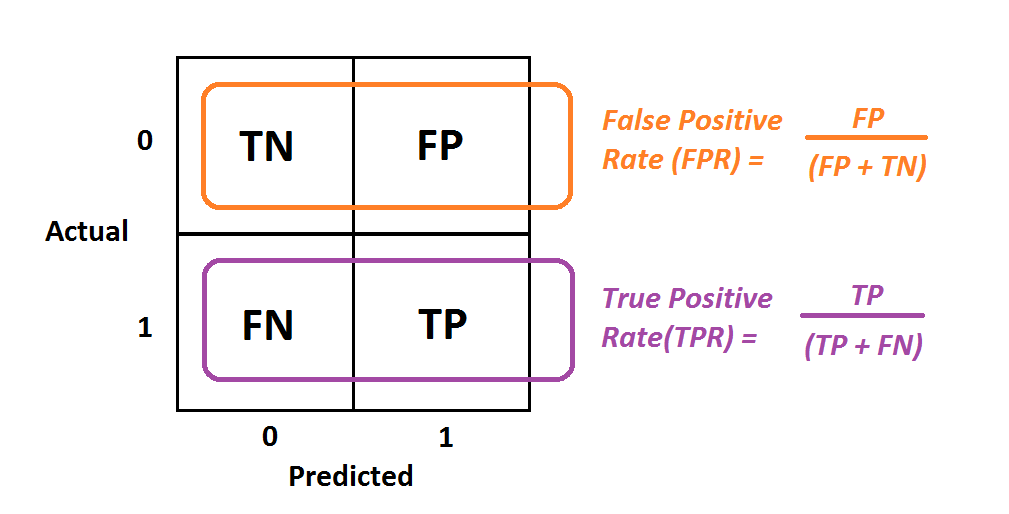

- Главное преимущество PR-AUC заключается в том, что эта метрика фокусируется только на положительном классе и не учитывает истинно отрицательные случаи.
Это кардинально отличается от ROC-AUC, где используется False Positive Rate (FPR)
- В отличие от ROC-AUC, базовая линия PR-AUC соответствует доле положительных примеров в датасете. Например, если положительный класс составляет 1% от данных, случайный классификатор будет иметь PR-AUC около 0.01, а не 0.5. Это делает PR-AUC более информативной - любое значение выше базовой линии показывает реальный прогресс


**Итого**

Используйте PR-AUC если:

- положительный класс составляет менее 5-10% от всех данных
- когда положительный класс составляет менее 0.1%, PR-AUC следует **использовать обязательно**
- важна точность выявления положительных примеров
- требуется адекватная оценка производительности на редком классе

ROC-AUC остаётся предпочтительным если:

- классы примерно сбалансированы (соотношение 40/60, 30/70 и т.п.)
- оба класса одинаково важны для задачи
- требуется метрика, независимая от порога классификации

### Random Forest и его адаптации под дисбаланс

In [27]:
%%time

rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
).fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:, 1]
report_metrics(y_test, proba_rf, title="RF default")

RF default
ROC-AUC=0.9794  PR-AUC=0.9228  Brier=0.0012
Confusion threshold=0.50: TP=86 FP=2 FN=12 TN=11999
CPU times: user 4min 20s, sys: 622 ms, total: 4min 21s
Wall time: 3min 21s


`class_weight="balanced"` - сбалансированный режим, использует значения `y` для автоматической корректировки весов обратно пропорционально частотам классов во входных данных, как `n_samples / (n_classes * count_class)`

In [44]:
%%time

rf_weighted = RandomForestClassifier(
    n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=42
).fit(X_train, y_train)

proba_rf_weighted = rf_weighted.predict_proba(X_test)[:, 1]
report_metrics(y_test, proba_rf_weighted, title="RF class_weight=balanced")

RF class_weight=balanced
ROC-AUC=0.9807  PR-AUC=0.9231  Brier=0.0012
Confusion threshold=0.50: TP=83 FP=1 FN=15 TN=12000
CPU times: user 2min 22s, sys: 294 ms, total: 2min 22s
Wall time: 1min 24s


Вместо взвешивания примеров, BalancedRandomForestClassifier применяет автоматический under-sampling на каждой итерации бутстрапа:
- Для каждого дерева создаётся отдельная сбалансированная бутстреп-выборка
- Берутся все примеры из класса меньшинства
- Из класса большинства случайным образом отбирается такое же количество примеров (с возвращением)
- Дерево обучается на этой сбалансированной подвыборке

In [42]:
%%time

brf = BalancedRandomForestClassifier(
    n_estimators=300, sampling_strategy='auto', n_jobs=-1, random_state=42
).fit(X_train, y_train)

proba_brf = brf.predict_proba(X_test)[:, 1]
report_metrics(y_test, proba_brf, title="Balanced Random Forest")

Balanced Random Forest
ROC-AUC=0.9850  PR-AUC=0.9147  Brier=0.0321
Confusion threshold=0.50: TP=93 FP=348 FN=5 TN=11653
CPU times: user 6.7 s, sys: 117 ms, total: 6.81 s
Wall time: 5.04 s


BalancedRandomForestClassifier существенно ускоряет обучение, уменьшая размер каждой обучающей выборки, борется с шумом в миноритарном классе

### XGBoost

In [52]:
%%time

pos = y_train.sum(); neg = len(y_train) - pos
spw = neg / pos  # соотношение классов

xgb = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)
xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)
proba_xgb = xgb.predict_proba(X_test)[:,1]
report_metrics(y_test, proba_xgb, title=f"XGB (scale_pos_weight={spw:.1f})")

XGB (scale_pos_weight=121.8)
ROC-AUC=0.9846  PR-AUC=0.9266  Brier=0.0013
Confusion threshold=0.50: TP=87 FP=8 FN=11 TN=11993
CPU times: user 14 s, sys: 25.2 ms, total: 14 s
Wall time: 13.3 s


`scale_pos_weight` умножает градиенты и гессианы для примеров положительного класса на заданное значение. Это заставляет алгоритм придавать больше важности ошибкам на примерах положительного класса при выборе разбиений в деревьях.

### XGBoost + кастомный loss

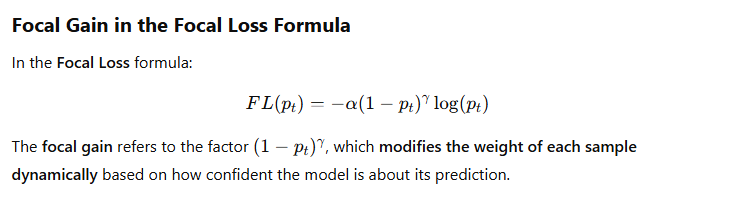

In [53]:
def focal_loss(alpha=0.25, gamma=2.0):
    def fl_obj(preds, dtrain):
        y = dtrain.get_label()
        p = 1.0 / (1.0 + np.exp(-preds))  # logits -> prob
        grad = (alpha*(1-p)**gamma*(p - y) +
                (1-alpha)*p**gamma*(p - y))  # симметричный вариант
        hess = (alpha*(1-p)**gamma*(p*(1-p)*(1 + gamma*(1-2*p))) +
                (1-alpha)*p**gamma*(p*(1-p)*(1 + gamma*(2*p-1))))
        return grad, hess
    return fl_obj

`alpha = 0.25` - баланс между двумя классами, больше weight на положительный класс (1)

`gamma = 2.0` -	Фокусирующий коэффициент, сильнее игнорирует легкие примеры

In [57]:
%%time

xgb_focal = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    obj=focal_loss(alpha=0.25, gamma=2.0),
)
xgb_focal.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)
proba_xgb_focal = xgb_focal.predict_proba(X_test)[:,1]
report_metrics(y_test, proba_xgb_focal, title="XGB Focal Loss")

XGB Focal Loss
ROC-AUC=0.9893  PR-AUC=0.9287  Brier=0.0012
Confusion threshold=0.50: TP=85 FP=3 FN=13 TN=11998
CPU times: user 6.62 s, sys: 20.2 ms, total: 6.64 s
Wall time: 6.39 s


### Ресемплинг

In [59]:
%%time
pipe_smote_lr = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
])
pipe_smote_lr.fit(X_train, y_train)
proba_smote_lr = pipe_smote_lr.predict_proba(X_test)[:,1]
report_metrics(y_test, proba_smote_lr, title="SMOTE + LogisticRegression")

SMOTE + LogisticRegression
ROC-AUC=0.9673  PR-AUC=0.8671  Brier=0.0181
Confusion threshold=0.50: TP=90 FP=218 FN=8 TN=11783


In [60]:
%%time
pipe_unders_rf = Pipeline(steps=[
    ('under', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])
pipe_unders_rf.fit(X_train, y_train)
proba_unders_rf = pipe_unders_rf.predict_proba(X_test)[:,1]
report_metrics(y_test, proba_unders_rf, title="UnderSample + RF")

UnderSample + RF
ROC-AUC=0.9838  PR-AUC=0.8745  Brier=0.0341
Confusion threshold=0.50: TP=92 FP=396 FN=6 TN=11605
CPU times: user 3.24 s, sys: 46.5 ms, total: 3.29 s
Wall time: 3.13 s


**Resampling помогает линейным моделям**

- Линейные модели (логистическая регрессия, линейная регрессия) ищут глобальную гиперплоскость, которая минимизирует ошибку на всех данных. Они НЕ имеют встроенной поддержки взвешивания примеров внутри алгоритма оптимизации -> модель просто изменяет потери но алгоритм оптимизации всё равно может игнорировать меньшинство.
- На больших данных меньшинство может не попасть в batch или быть усреднено в стохастическом градиентном спуске

**Class weights хорошо помогает бустингам**
- Градиентный бустинг растёт на сложных примерах. При каждой итерации новое дерево учится на остатках предыдущего дерева. Веса напрямую влияют на критерий расщепления

### Выбор порогов

In [71]:
def threshold_for_precision(y_true, y_proba, target_precision=0.9):
    p, r, th = precision_recall_curve(y_true, y_proba)
    # th соответствует p, r кроме первой точки
    th = np.r_[1.0, th]
    mask = p >= target_precision
    if not mask.any():
        return 1.0  # ничего не удовлетворяет
    best_idx = np.argmax(r[mask])  # макс recall при нужной precision
    return th[mask][best_idx]

In [74]:
t = threshold_for_precision(y_test, proba_xgb_focal, target_precision=0.9)
report_metrics(y_test, proba_xgb_focal, threshold=t, title=f"XGB @ P>=0.90 (t={t:.3f})")

XGB @ P>=0.90 (t=0.279)
ROC-AUC=0.9893  PR-AUC=0.9287  Brier=0.0012
Confusion threshold=0.28: TP=88 FP=10 FN=10 TN=11991


Бизнес-стоимость

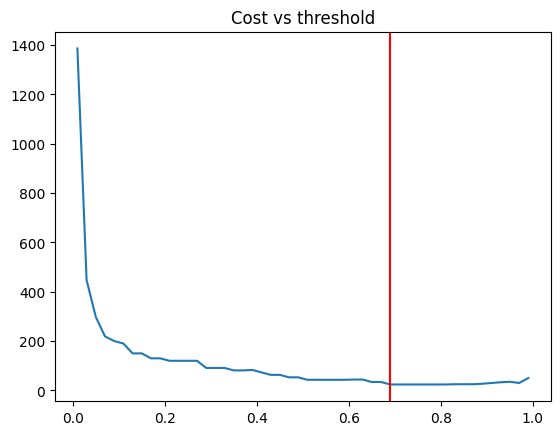

(np.float64(0.6900000000000001), np.int64(24))

In [79]:
def cost_at_threshold(y_true, y_proba, threshold, cost_fp=1.0, cost_fn=50.0):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp*cost_fp + fn*cost_fn

ths = np.linspace(0.01, 0.99, 50)
costs = [cost_at_threshold(y_test, proba_xgb_focal, t, cost_fp=10, cost_fn=1) for t in ths]
best_t = ths[np.argmin(costs)]
plt.plot(ths, costs); plt.axvline(best_t, color='r'); plt.title("Cost vs threshold"); plt.show()
best_t, min(costs)

Порог при плавающей стоимости ошибок - минимизирует худший случай среди всех возможных стоимостей в указанных диапазонах.

In [81]:
def cost_at_threshold(y_true, y_proba, t, cost_fp, cost_fn):
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp*cost_fp + fn*cost_fn

def robust_threshold(y_true, y_proba, cost_fp_range=(10, 50), cost_fn_range=(1, 5), ts=np.linspace(0.01, 0.99, 200)):
    worst_costs = []
    for t in ts:
        # худший случай по сетке стоимостей
        worst = 0
        for cfp in np.linspace(*cost_fp_range, 10):
            for cfn in np.linspace(*cost_fn_range, 10):
                worst = max(worst, cost_at_threshold(y_true, y_proba, t, cfp, cfn))
        worst_costs.append(worst)
    t_star = ts[int(np.argmin(worst_costs))]
    return t_star

t_robust = robust_threshold(y_test, proba_xgb_focal)
t_robust

np.float64(0.6895979899497487)

Робастность может снизить среднюю прибыль; согласуйте с бизнесом диапазоны стоимостей